# Pose Classification with a Naive Bayes Model made from Scratch


In [20]:
import numpy as np 
import math
from collections import defaultdict
import pandas as pd

In [21]:
def preprocess(filename, class_num, values, labels):
    with open(filename, mode = 'r') as fin:
        for line in fin:
            atts = line.strip().split(",")
            values.append(atts[1:])       # 11 x & 11 y values
            labels.append(atts[0])        # ground truth labels
            class_num[atts[0]] += 1       # no. of instances per class

In [22]:
# calculates prior probabilities and likelihoods from the training data and uses them to build a naive Bayes model
def train(class_num, values, labels, mean_set, sd_set, log_prior_set):
    
    valid_class_num = defaultdict(int)
    total_class_num = 0
    
    for class_label in class_num:
        total_class_num += class_num[class_label]                  # total no. of instances
        for j in range(len(values[0])):
            key = str(class_label) + ' attribute ' + str(j + 1)    # e.g. bridge attribute 1, bridge attribute 2,...
            valid_class_num[key] = class_num[class_label]          # assign no. of instances per class x attribute pairing
        
    for i in range(len(labels)):
        for j in range(len(values[0])):
            key = str(labels[i]) + ' attribute ' + str(j + 1)
            if (float(values[i][j]) != float(9999)):
                if (mean_set[key] == None):
                    mean_set[key] = 0
                mean_set[key] += float(values[i][j])    # sum up non-missing attribute values
            else:
                if (key not in mean_set):
                    mean_set[key] = None
                valid_class_num[key] -= 1               # deduct no. of valid instances per class x attribute pairing 
                                                        # for missing values
    for key in mean_set.keys():
        mean_set[key] = (mean_set[key]/valid_class_num[key])       # take mean of the sum
        
    for i in range(len(labels)):
        for j in range(len(values[0])):
            key = str(labels[i]) + ' attribute ' + str(j + 1)
            if (float(values[i][j]) != float(9999)):
                if (sd_set[key] == None):
                    sd_set[key] = 0
                sd_set[key] += (float(values[i][j]) - mean_set[key])**2    # sum up square of residuals of
            else:                                                          # non-missing values - mean
                if (key not in sd_set):
                    sd_set[key] = None
    
    for key in sd_set.keys():
        sd_set[key] = math.sqrt(sd_set[key]/(valid_class_num[key] - 1))    # take sd of the residuals
        
    for key,value in class_num.items():
        log_prior_set[key] = math.log(value/total_class_num)

In [23]:
# gaussian log likelihood pdf
def gaussian(mean,sd,x):
    inside = (1 /(sd * (math.sqrt(2 * math.pi)))) * math.exp(-0.5*((x - mean)/sd)**2)     # Gaussian pdf
    if inside == 0:
        inside = np.finfo(float).eps            # replace pdfs that equal to 0 with epsilon
    return math.log(inside)                     # return log likelihood

In [24]:
# predicts classes for new items in a test dataset
def predict(mean_set, sd_set, log_prior_set, test_value):
    
    log_likelihood_set = defaultdict(float)
    classifier_set = defaultdict(float)
    
    for label in log_prior_set.keys():
        index = 0
        for att in mean_set.keys():
            if (att.startswith(label)):                         # e.g. if "bridge attribute 1" starts with "bridge"
                if (float(test_value[index]) != float(9999)):   # sum up log likelihoods of non-missing values
                    log_likelihood_set[label] += gaussian(float(mean_set[att]), float(sd_set[att]), float(test_value[index]))
                index += 1
        
    for key in log_prior_set.keys():
        classifier_set[key] = log_likelihood_set[key] + log_prior_set[key]    # add up log likelihoods and log priors
        
    top_predict_class = list(classifier_set)[0]
    top_predict_value = classifier_set[top_predict_class]
    for key in classifier_set:
        if (classifier_set[key] > top_predict_value):      # finding class with the max log likelihood + log prior
            top_predict_class = key
            top_predict_value = classifier_set[key]
        
    return top_predict_class

In [25]:
# evaluates the prediction performance by comparing model’s class outputs to ground truth labels
def evaluate(mean_set, sd_set, log_prior_set, test_values, test_labels):
    
    true_positives = 0
    total = len(test_values)
    
    for i in range(len(test_values)):
        if (predict(mean_set, sd_set, log_prior_set, test_values[i]) == test_labels[i]):
            true_positives += 1
    
    result = "Accuracy is: " + str(true_positives/total)
    
    return result

In [26]:
train_nums = defaultdict(int)
train_values = []
train_labels = []
preprocess("train.csv", train_nums, train_values, train_labels)
test_nums = defaultdict(int)
test_values = []
test_labels = []
preprocess("test.csv", test_nums, test_values, test_labels)

train_mean_set = defaultdict(float)
train_sd_set = defaultdict(float)
train_log_prior_set = defaultdict(float)
train(train_nums, train_values, train_labels, train_mean_set, train_sd_set, train_log_prior_set)

evaluate(train_mean_set, train_sd_set, train_log_prior_set, test_values, test_labels)

'Accuracy is: 0.7155172413793104'

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [27]:
def evaluate2(mean_set, sd_set, log_prior_set, test_values, test_labels, test_nums):
    
    class_true_positives = defaultdict(int)
    class_false_positives = defaultdict(int)
    class_false_negatives = defaultdict(int)
    total = len(test_values)
    
    for key in log_prior_set.keys(): # calculates tps, fps, and, fns for each class in a one vs. rest multiclass evaluation
        class_true_positives[key] = 0
        class_false_positives[key] = 0
        class_false_negatives[key] = 0
        for i in range(len(test_values)):
            if ((predict(mean_set, sd_set, log_prior_set, test_values[i]) == key) and (test_labels[i] != key)):
                class_false_positives[key] += 1
            elif ((predict(mean_set, sd_set, log_prior_set, test_values[i]) != key) and (test_labels[i] == key)):
                class_false_negatives[key] += 1
            elif ((predict(mean_set, sd_set, log_prior_set, test_values[i]) == key) and (test_labels[i] == key)):
                class_true_positives[key] += 1
    
    class_precision = defaultdict(float)
    class_recall = defaultdict(float)
    
    for key,value in class_true_positives.items(): # calculates precision and recall for each class
        class_precision[key] = (value/(value + class_false_positives[key]))
        class_recall[key] = (value/(value + class_false_negatives[key]))
        
    p = "precision"
    r = "recall"
    
    macro_avg = {p: 0.0, r: 0.0} # adds precision and recall values before dividing by total no. of classes
    weighted_avg = {p: 0.0, r: 0.0} # multiply precision and recall with the proportion of the classes before adding them
    
    for key,value in class_precision.items():
        macro_avg[p] += value
        weighted_avg[p] += ((test_nums[key]/total)*value)
    
    for key,value in class_recall.items():
        macro_avg[r] += value
        weighted_avg[r] += ((test_nums[key]/total)*value)
    
    for key in macro_avg.keys(): # divides precision and recall added values by total no. of classes
        macro_avg[key] = macro_avg[key]/len(log_prior_set)
    
    # F-score here uses beta value 1 (2*P*R/(P + R))
    macro_avg["F-score"] = ((2*macro_avg[p]*macro_avg[r])/(macro_avg[p] + macro_avg[r]))
    weighted_avg["F-score"] = ((2*weighted_avg[p]*weighted_avg[r])/(weighted_avg[p] + weighted_avg[r]))
    
    print("Macro-Averaging: " + str(macro_avg) + "\nWeighted-Averaging: " + str(weighted_avg))

In [28]:
evaluate2(train_mean_set, train_sd_set, train_log_prior_set, test_values, test_labels, test_nums)

Macro-Averaging: {'precision': 0.6975877192982457, 'recall': 0.7078296703296703, 'F-score': 0.7026713758076242}
Weighted-Averaging: {'precision': 0.7261897559991934, 'recall': 0.7155172413793102, 'F-score': 0.7208139960134242}


# Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

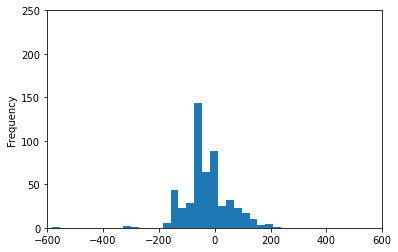

In [8]:
#Box 1
data = pd.read_csv('train.csv', sep=',',header=None, index_col =0)
column1 = data.iloc[:,3]
length = round(len(column1)/2)
graph1 = column1.plot.hist(bins = length, xlim = (-600,600), ylim = (0,250)).get_figure()
graph1.savefig("x4, wristR")

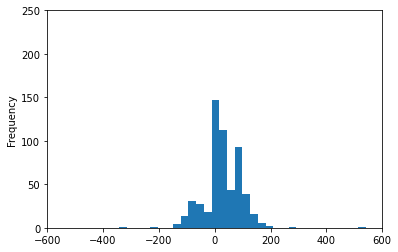

In [9]:
#Box 2
column2 = data.iloc[:,9]
length2 = round(len(column2)/2)
graph2 = column2.plot.hist(bins = length2, xlim = (-600,600), ylim = (0,250)).get_figure()
graph2.savefig("x10, kneeL")

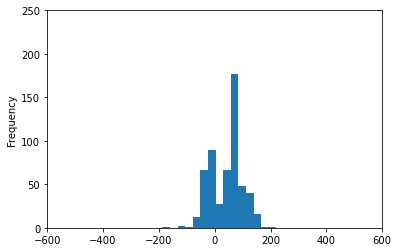

In [10]:
#Box 3
column3 = data.iloc[:,15]
length3 = round(len(column3)/2)
graph3 = column3.plot.hist(bins = length3, xlim = (-600,600), ylim = (0,250)).get_figure()
graph3.savefig("y5, elbowL")

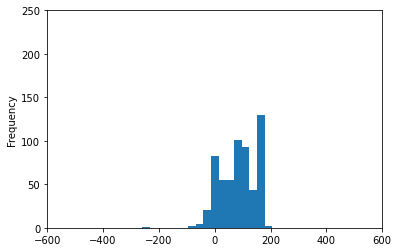

In [11]:
#Box 4
column4 = data.iloc[:,11]
length4 = round(len(column4)/2)
graph4 = column4.plot.hist(bins = length4, xlim = (-600,600), ylim = (0,250)).get_figure()
graph4.savefig("y1, head")

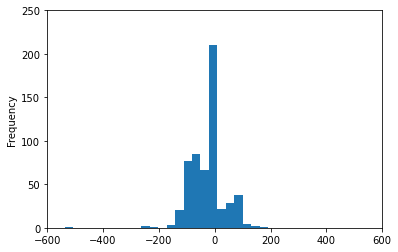

In [12]:
#Box 5
column5 = data.iloc[:,7]
length5 = round(len(column5)/2)
graph5 = column5.plot.hist(bins = length5, xlim = (-600,600), ylim = (0,250)).get_figure()
graph5.savefig("x8, kneeR")


### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [29]:
def KDE_gaussian(mean,sd,x):                    # gaussian likelihood pdf used in 
    inside = (1 /(sd * (math.sqrt(2 * math.pi)))) * math.exp(-0.5*((x - mean)/sd)**2)     # Gaussian pdf
    if inside == 0:
        inside = np.finfo(float).eps            # replace pdfs that equal to 0 with epsilon
    return inside                               # return likelihood

In [30]:
def KDE_predict(values, labels, mean_set, log_prior_set, test_value, sd):
    
    valid_class_att_nums = defaultdict(int)
    KDE_class_att_likelihood_set = defaultdict(float)
    log_KDE_likelihood_set = defaultdict(float)
    classifier_set = defaultdict(float)
    
    index = 0
    for att in mean_set.keys():                  # e.g. 'bridge attribute 1'
        for i in range(len(values)):             # length of training set
            if (att.startswith(labels[i])):      # e.g. 'bridge attribute 1' starts with 'bridge'
                if (float(values[i][index]) != float(9999)):       # calculates no. of valid instances per class attribute in training set
                    valid_class_att_nums[att] += 1
                    if (float(test_value[index]) != float(9999)):  # adds up test instance values of class attribute that are non-missing
                        # uses mean 0, an assigned sd, & the residual between the class attribute values of the test instance & every train instance
                        KDE_class_att_likelihood_set[att] += KDE_gaussian(0, sd, float(test_value[index]) - float(values[i][index]))
        if (index == 21): # refreshes the index of the 22 attributes for each class
            index = 0
        else:
            index += 1
            
    for att in KDE_class_att_likelihood_set.keys(): # divides the sum by the no. of valid class attribute instances in training set
        KDE_class_att_likelihood_set[att] = KDE_class_att_likelihood_set[att]/valid_class_att_nums[att]
        
    for label in log_prior_set.keys():
        index = 0
        for att in KDE_class_att_likelihood_set.keys(): # calculates log KDE likelihood of each class
            if (att.startswith(label)):
                log_KDE_likelihood_set[label] += math.log(KDE_class_att_likelihood_set[att])
            index += 1
        
    for key in log_prior_set.keys(): # add up log likelihoods and log priors
        classifier_set[key] = log_KDE_likelihood_set[key] + log_prior_set[key]
        
    top_predict_class = list(classifier_set)[0]
    top_predict_value = classifier_set[top_predict_class]
    for key in classifier_set:
        if (classifier_set[key] > top_predict_value): # finding class with the max log likelihood + log prior
            top_predict_class = key
            top_predict_value = classifier_set[key]
        
    return top_predict_class

In [31]:
def KDE_evaluate(values, labels, mean_set, log_prior_set, test_values, test_labels, sd):
    
    true_positives = 0
    total = len(test_values)
    
    for i in range(len(test_values)):
        if ((KDE_predict(values, labels, mean_set, log_prior_set, test_values[i], sd)) == test_labels[i]):
            true_positives += 1
    
    result = "Accuracy is: " + str(true_positives/total)
    
    return result

In [32]:
# we just used kernel value of 10 here arbitrarily
KDE_evaluate(train_values, train_labels, train_mean_set, train_log_prior_set, test_values, test_labels, 10)

'Accuracy is: 0.7758620689655172'

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [18]:
# This function calculates prior probabilities 
  
def kernal_train(class_num, values, labels, log_prior_set):
    
    valid_class_num = defaultdict(int)
    total_class_num = 0
    
    # initialises the dictionary that will eventually contain valid classes
    for class_label in class_num:
        total_class_num += class_num[class_label]
        for j in range(len(values[0])):
            key = str(class_label) + ' attribute ' + str(j + 1)
            valid_class_num[key] = class_num[class_label]
    
    # obtains the number of valid classes (non-9999 classes)
    for i in range(len(labels)):
        for j in range(len(values[0])):
            key = str(labels[i]) + ' attribute ' + str(j + 1)
            if (float(values[i][j]) == float(9999)):
                valid_class_num[key] -= 1
    
    # calculates the prior probabilites for each class
    for key,value in class_num.items():
        log_prior_set[key] = math.log(value/total_class_num)

In [ ]:
def cross_validation(file, partitions_values, partitions_labels, train_mean_set):
    
    # initialises the dictionaries with empty lists
    values = []
    labels = []
    for i in range(10):
        key = 'partition ' + str(i+1)
        partitions_values[key] = []
        partitions_labels[key] = []
    
    # reads the csv file into a dataframe
    df = pd.read_csv('train.csv', header=None)
    ds = df.sample(frac=1)    # randomly shuffles the rows of the dataframe (randomises the data)
    for line in ds.values:
        values.append(line[1:])    # stores only the values of the entire dataset
        labels.append(line[0])    # stores only the classes of each row in the dataset
        
    partition_num = 1
    count = 0
    
    # creates 10 partitions from the data set, where 9 partitions has 75 instances and 1 partition has 72 instances
    for i in range(len(values)):
        key = 'partition ' + str(partition_num)
        partitions_values[key].append(values[i]) 
        partitions_labels[key].append(labels[i])
        
        if count == 74:
            partition_num += 1
            count = -1
        count += 1
    
    # iterates over each partition
    accuracy_sd_set = defaultdict(float)
    for i in range(10):   
        test_key = 'partition ' + str(i+1)    # stores the test key
        test_values = partitions_values[test_key]    # stores the test set values
        test_labels = partitions_labels[test_key]    # stores the test set labels
        train_values = []
        train_labels = []
        train_class_num = defaultdict(int)
        train_log_prior_set = defaultdict(float)    
        
        # to get training values and labels
        for j in range(10):
            train_key = 'partition ' + str(j+1)
            
            if train_key != test_key:
                
                for line in partitions_values[train_key]:
                    train_values.append(line)    # stores training set values
                
                for line in partitions_labels[train_key]:
                    train_labels.append(line)    # stores the training set labels
        
        # obtains the number of classes 
        for label in train_labels:
            train_class_num[label] += 1
          
        kernal_train(train_class_num, train_values, train_labels, train_log_prior_set)    #trains the data to obtain prior probabilities
        
        # iterates through the different kernel banwidths (5 through 25) and adds them to the dictionary
        for k in range(5,26):
            accuracy_sd_set[k] += float(KDE_evaluate(train_values, train_labels, train_mean_set, train_log_prior_set, test_values, test_labels, k).split(' ')[-1])
    
    top_kernal = 5
    top_kernal_value = accuracy_sd_set[5]
    
    # obtains the optimal kernel by finding the highest accuracy
    for key, value in accuracy_sd_set.items():
        if value > top_kernal_value:
            top_kernal = key
            top_kernal_value = value
        
    return top_kernal, accuracy_sd_set    # returns the optimal kernel and the accuracy for each kernel

In [ ]:
partitions_values = defaultdict(list)
partitions_labels = defaultdict(list)
cross_validation('train.csv', partitions_values, partitions_labels, train_mean_set)